This notebook performs an analysis of all the station data since 1980. It ultimately segregates this into multiple station sets since the data coverage in this set is determined below to be sparse.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load the stations file

In [11]:
stations_file = 'Salish Sea met stations.csv'
stations = pd.read_csv(stations_file)
stations.head()

,ISD number,Name
0,727935-24234,Boeing Field
1,727935-99999,Boeing Field King Co
2,727976-24217,Bellingham Airport
3,720749-24255,Whidbey Airport
4,727923-94225,Hoquiam Airport


Load the data file for all the stations since 1980, created with ProcessClimateData.ipynb

In [53]:
df = pd.read_hdf("data/climate_data_all_since_1980.h5", 'all1980', parse_dates=[1])
df.head()

,station_id,date,temp,dewpt,slp_hpa,wind_dir,wind_speed,skycond,precip_1hr,precip_6hr
0,727935-24234,1990-01-01 00:00:00,7.8,6.1,NaN,190.0,5.1,7.0,NaN,NaN
1,727935-24234,1990-01-01 01:00:00,8.3,6.7,NaN,180.0,6.7,8.0,NaN,NaN
2,727935-24234,1990-01-01 02:00:00,7.8,6.1,NaN,190.0,6.7,8.0,NaN,NaN
3,727935-24234,1990-01-01 03:00:00,7.8,6.1,NaN,190.0,5.1,8.0,NaN,NaN
4,727935-24234,1990-01-01 04:00:00,7.8,6.1,NaN,190.0,5.1,8.0,NaN,NaN


How many stations have at least some data for each year?

[Text(0, 0.5, 'Unique stations with >1 wind observation'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Number of wind observing stations by year')]

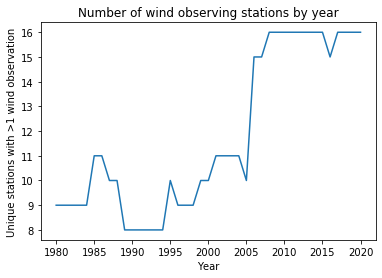

In [10]:
years = df['date'].dt.year.sort_values().unique()
station_count = np.zeros_like(years)
for i, year in enumerate(years):
    # Get all the wind observations made in this year, then drop any rows which do not contain at least one
    # observation of wind (station_id is guaranteed to be non-NaN, so the threshold needs to be two)
    data_this_year = df.loc[df['date'].dt.year == year, ['station_id','wind_speed','wind_dir']].dropna(thresh=2)
    station_count[i] = len(data_this_year.groupby('station_id').count())
fig, ax = plt.subplots()
ax.plot(years, station_count)
ax.set(title="Number of wind observing stations by year", xlabel="Year", ylabel="Unique stations with >1 wind observation")

## Extract the Long-Run Station IDs

Okay, so there is not a record that is both spatially detailed and goes back many decades. Instead, let's figure out which stations go back the longest (there are at most 8 of those), and exactly which year all 16 recent stations came online.

Let's start by looking at all the unique station IDs for 1990, and merging with the stations list to see which those are.

In [15]:
stationids_1990 = df.loc[df['date'].dt.year == 1990, 'station_id'].unique()
stations.loc[stations['ISD number'].isin(stationids_1990)]

,ISD number,Name
0,727935-24234,Boeing Field
2,727976-24217,Bellingham Airport
5,727970-94240,Quillayute Airport
6,727930-24233,Seatac Airport
7,727920-24227,Olympia Airport
13,742065-99999,Point No Point CG Station
14,994350-99999,West Point
19,714730-99999,Saturna Island


Do all of those stations have data up to the last year we fetched?

[Text(0, 0.5, 'Observations per month'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Wind Speed observations per month for all active stations as of 1990')]

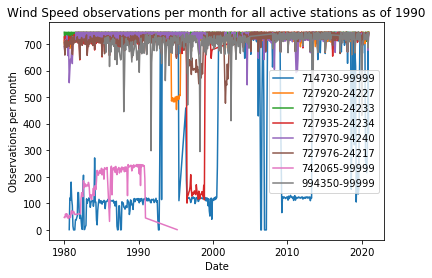

In [43]:
years = df['date'].dt.year.sort_values().unique()
longrun_data = df.loc[df['station_id'].isin(stationids_1990), ['station_id','date','wind_speed','wind_dir']].dropna(thresh=2)
longrun_data['yearmonth'] = longrun_data['date'].dt.year + (longrun_data['date'].dt.month - 1) / 12
counts = longrun_data.groupby(['station_id','yearmonth']).count()
fig, ax = plt.subplots()
for name,group in counts.groupby(level=0):
    ax.plot(group.index.get_level_values(1).to_numpy(), group['wind_speed'].to_numpy(), label=name)
ax.legend()
ax.set(title="Wind Speed observations per month for all active stations as of 1990", ylabel="Observations per month", xlabel="Date")

Okay, so Saturna Island (714730-99999) and Point No Point (742065-99999) stations do not have much data. We need to exclude those, leaving us with only six stations. The others look like they only have brief blips of unavailability.

In [40]:
longrun_stationids = stationids_1990[(stationids_1990 != '714730-99999') & (stationids_1990 != '742065-99999')]
longrun_stationids

array(['727935-24234', '727920-24227', '727930-24233', '994350-99999',
       '727976-24217', '727970-94240'], dtype=object)

Create a subset of the overall stations CSV with just these six stations listed. This gets used to fetch climate data from ISD-Lite going back as far as we can

In [42]:
longrun_stations = stations.loc[stations['ISD number'].isin(longrun_stationids)]
longrun_stations.to_csv('met_stations_longrun.csv', index=False)

## Extract the Recent Station IDs

This follows a similar process to above. Get a list of all stations with observations in 2010, of which there are 16, and see whether their observation records are complete. Remove any stations from consideration which are missing large amounts of data, and settle on a start year for this part of the analysis.

In [44]:
stationids_2010 = df.loc[df['date'].dt.year == 2010, 'station_id'].unique()
stations.loc[stations['ISD number'].isin(stationids_2010)]

,ISD number,Name
0,727935-24234,Boeing Field
2,727976-24217,Bellingham Airport
3,720749-24255,Whidbey Airport
4,727923-94225,Hoquiam Airport
5,727970-94240,Quillayute Airport
6,727930-24233,Seatac Airport
7,727920-24227,Olympia Airport
8,727925-94227,Shelton Airport
10,727938-94274,Tacoma Narrows Airport
11,727928-94263,Bremerton Airport


Do all of those stations have data up to the last year we fetched?

[Text(0, 0.5, 'Observations per month'),
 (2005, 2022.9625),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Wind Speed observations per month for all active stations as of 1990')]

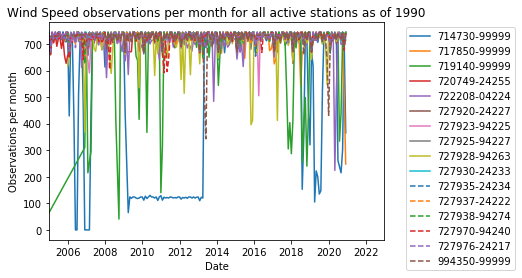

In [50]:
years = df['date'].dt.year.sort_values().unique()
recentdense_data = df.loc[df['station_id'].isin(stationids_2010), ['station_id','date','wind_speed','wind_dir']].dropna(thresh=2)
recentdense_data['yearmonth'] = recentdense_data['date'].dt.year + (recentdense_data['date'].dt.month - 1) / 12
counts = recentdense_data.groupby(['station_id','yearmonth']).count()
fig, ax = plt.subplots()
# The default matplotlib color cycler only has ten colors, so after ten plots
# the linestyle gets changed to dashed
i = 0
ls = '-'
for name,group in counts.groupby(level=0):
    i += 1
    ax.plot(group.index.get_level_values(1).to_numpy(), group['wind_speed'].to_numpy(), ls, label=name)
    if i % 10 == 0:
        ls = '--'
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set(title="Wind Speed observations per month for all active stations as of 1990", ylabel="Observations per month", xlabel="Date", xlim=(2005,None))

Similar to the longrun data, we can visually identify the need to exclude 714730-99999. 719140-99999 (Saturna Capmon) looks like it has lots of small gaps but it's probably okay to keep it. The best year to start this part of the analysis looks to be 2008.

In [51]:
recentdense_stationids = stationids_2010[stationids_2010 != '714730-99999']
recentdense_stationids

array(['727928-94263', '727976-24217', '720749-24255', '717850-99999',
       '727938-94274', '727937-24222', '727923-94225', '994350-99999',
       '727970-94240', '719140-99999', '727935-24234', '727925-94227',
       '727920-24227', '727930-24233', '722208-04224'], dtype=object)

In [52]:
recentdense_stations = stations.loc[stations['ISD number'].isin(recentdense_stationids)]
recentdense_stations.to_csv('met_stations_recentdense.csv', index=False)